<a href="https://colab.research.google.com/github/nvvishnu/CS6910-Assignments/blob/main/Assignment%203/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import csv
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
!pip install wandb
import wandb
from wandb.keras import WandbCallback 
import pandas as pd
!pip install dataframe-image
import dataframe_image as dfi

     |████████████████████████████████| 1.8MB 28.7MB/s 
     |████████████████████████████████| 174kB 52.9MB/s 
     |████████████████████████████████| 133kB 59.9MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=20fd02098a0a6f3fac7e0ba957866b0de19072b8e229c52c98f5c4eea79055fa
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=a68bbe049fbed1501e3aa14d027adb6b8bdbfbbbf28fa6cc8bb8d8e182866718
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
     |████████████████████████████████| 1.3MB 41.3MB/s 
     |████████████████████████████████| 143kB 35.2MB/s 
     |█████████████████████████████

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train data preprocessing

In [3]:
datapath = "/content/drive/MyDrive/Assignment3/hi/lexicons/hi.translit.sampled.train.tsv" #add path here after mounting drive 
input_texts = []
target_texts = []
expected_texts = []
input_characters = set([' '])
target_characters = set([' '])
f = open(datapath)
lines = csv.reader(f,delimiter='\t')
 
for row in lines:
    input_text = row[1]
    target_text = row[0]
    #adding '\t' as start and '\n' as stop
    expected_texts.append(target_text)
    target_text = "\t"+target_text+"\n"
    
 
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
 
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
 
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
 
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
 
encoder_input_data = np.zeros((len(input_texts),max_encoder_seq_length),dtype='float32')
decoder_input_data = np.zeros((len(input_texts),max_decoder_seq_length),dtype='float32')
decoder_target_data = np.zeros((len(input_texts),max_decoder_seq_length,num_decoder_tokens),dtype='float32')
 
 
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    
    for t,char in enumerate(input_text):
       encoder_input_data[i,t] = input_token_index[char]
 
    encoder_input_data[i,t+1:] = input_token_index[' ']
 
    for t,char in enumerate(target_text):
        decoder_input_data[i,t] = target_token_index[char]
        if(t>0):
          decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    
    decoder_input_data[i,t+1:] = target_token_index[' ']
    decoder_target_data[i,t:,target_token_index[' ']] = 1.0

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

Number of samples: 44204
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


# Val data Preprocessing


In [4]:
val_datapath = "/content/drive/MyDrive/Assignment3/hi/lexicons/hi.translit.sampled.dev.tsv"
val_f = open(val_datapath)
lines = csv.reader(val_f,delimiter='\t')
val_input_texts = []
val_expected_texts = []
for row in lines:
    input_text = row[1]
    target_text = row[0]
    #adding '\t' as start and '\n' as stop
    val_expected_texts.append(target_text)
    val_input_texts.append(input_text)

max_val_encoder_seq_length = max([len(txt) for txt in val_input_texts])

val_encoder_input_data = np.zeros((len(val_input_texts),max_val_encoder_seq_length),dtype='float32')

for i,input_text in enumerate(val_input_texts):
    
    for t,char in enumerate(input_text):
       val_encoder_input_data[i,t] = input_token_index[char]
 
    val_encoder_input_data[i,t+1:] = input_token_index[' ']


# Test data processing


In [5]:
test_datapath = '/content/drive/MyDrive/Assignment3/hi/lexicons/hi.translit.sampled.test.tsv'
test_f = open(test_datapath)
lines = csv.reader(test_f,delimiter='\t')
test_input_texts = []
test_expected_texts = []
for row in lines:
    input_text = row[1]
    target_text = row[0]
    #adding '\t' as start and '\n' as stop
    test_expected_texts.append(target_text)
    test_input_texts.append(input_text)

max_test_encoder_seq_length = max([len(txt) for txt in test_input_texts])

test_encoder_input_data = np.zeros((len(test_input_texts),max_test_encoder_seq_length),dtype='float32')

for i,input_text in enumerate(test_input_texts):
    
    for t,char in enumerate(input_text):
       test_encoder_input_data[i,t] = input_token_index[char]
 
    test_encoder_input_data[i,t+1:] = input_token_index[' ']


# Model definitions

In [6]:
#Function to get the vanilla model as well as inference models as well

# <num_encoder_tokens> : Number of encoder tokens
# <num_decoder_tokens> : Number of decoder tokens
# <embedding_size> : embedding size of embedding layer
# <num_encoder_layers> : number of encoder layers
# <num_decoder_layers> : number of decoder layers
# <hidden_layer_size> : size of the hidden layer
# <cell_type> : It’s RNN cell type , it can be ‘RNN’,’LSTM’,’GRU’
# <drop_out> : The drop out

def get_model(num_encoder_tokens,num_decoder_tokens,embedding_size,num_encoder_layers,num_decoder_layers,hidden_layer_size,cell_type,drop_out):
    
    if(cell_type == 'LSTM'):
        rnn_cell = tf.keras.layers.LSTM
    elif(cell_type ==  'RNN'):
        rnn_cell = tf.keras.layers.SimpleRNN
    elif(cell_type == "GRU"):
        rnn_cell = tf.keras.layers.GRU
        

    encoder_inputs = tf.keras.Input(shape = (None,))
    encoder_out = tf.keras.layers.Embedding(input_dim = num_encoder_tokens,output_dim = embedding_size,name="encoderembedding")(encoder_inputs) 
  

    for i in range(num_encoder_layers):
        encoder_out,*encoder_states = rnn_cell(hidden_layer_size,return_sequences=True,return_state=True,dropout = drop_out,
                                               name="encoder_"+str(i))(encoder_out)

    decoder_inputs = tf.keras.Input(shape = (None,))
    decoder_out = tf.keras.layers.Embedding(input_dim = num_decoder_tokens,output_dim=embedding_size,name="decoderembedding")(decoder_inputs)
    
    for i in range(num_decoder_layers):
        decoder_out,*_ = rnn_cell(hidden_layer_size,return_sequences=True,return_state=True,dropout = drop_out,
                                  name="decoder_"+str(i))(decoder_out,initial_state = encoder_states)
    
    decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation="softmax",name="decoderdense")
    decoder_outputs = decoder_dense(decoder_out)

    model = tf.keras.Model([encoder_inputs,decoder_inputs], decoder_outputs)

    model.compile(
      optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )
     
    # "Inference Model"
    encoder_inputs = model.input[0]

    enocoder_output,*encoder_states = model.get_layer("encoder_"+str(num_encoder_layers-1)).output
    encoder_model = tf.keras.Model(encoder_inputs,encoder_states)

    decoder_inputs = model.input[1]
    decoder_out = model.get_layer("decoderembedding")(decoder_inputs)
    
    decoder_state_inputs = []
    decoder_state_outputs = []
    
    for i in range(num_decoder_layers):
      
      curr_layer = model.get_layer("decoder_"+str(i))
      if (cell_type == "LSTM"):
        decoder_in = [tf.keras.Input(shape=(encoder_states[0].shape[1],)),tf.keras.Input(shape=(encoder_states[0].shape[1],))]
      else:
        decoder_in = [tf.keras.Input(shape=(encoder_states[0].shape[1],))]
      
      decoder_state_inputs += decoder_in

      decoder_out,*decoder_states = curr_layer(decoder_out,initial_state=decoder_in)

      decoder_state_outputs += decoder_states
    
    dense_layer = model.get_layer('decoderdense')
    decoder_output = dense_layer(decoder_out)

    decoder_model = tf.keras.Model([decoder_inputs]+decoder_state_inputs,[decoder_output]+decoder_state_outputs)
    

    return [model,encoder_model,decoder_model]

# Beam search Inference

In [7]:

def fn(sequence):
    
    decoded_sentence = ""
    for i in sequence:
      sampled_char = reverse_target_char_index[i]
      if sampled_char == '\n':
         break
      decoded_sentence += sampled_char

    return decoded_sentence


def decode_sequence(input_seq,beam_size,encoder_model,decoder_model):
    
    num_samples = input_seq.shape[0]

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)   

    target_seq = np.zeros((num_samples,1))
    # # Populate the first character of target sequence with the start character.
    target_seq[:,0] = target_token_index["\t"]

    num_decoder_layers = 0

    for layer in decoder_model.layers:
        if layer.name.startswith('decoder_') :
           num_decoder_layers += 1
    
    #Shape (None,list(list))
    sequence_list = [[list()] for i in range(num_samples)]
    
    #shape (None,curr_beamsize)
    sequence_score = np.empty(shape=(num_samples,1),dtype=object)
    sequence_score.fill(0.0)
    
    if(type(states_value) != list):
      states_value = [states_value]
    
    sequence_state = [states_value*num_decoder_layers]

    
    num_states = len(sequence_state[0])
    #print("num_states",num_states)
   
    #intially curr_beam size 1 after 1st prediction we set it back to beam_size
    k = 1

    for ii in range(max_decoder_seq_length):
        
        # shape (None,list)
        all_candidates = [ [] for i in range(num_samples) ]

        for x in range(k):
            
            #seq is (None,curr_seq)  curr_seq means list found till now
            seq = [sequence_list[i][x] for i in range(num_samples)]

            #score is (None,1) it is score of all samples xth sequence
            score = sequence_score[:,x]

            #curr_state is the state_corresponding to xth sequence for all samples 
            curr_state = sequence_state[x]

            if(ii>0):
                 #filling the target_seq with previous elements of this xth sequence for all samples 
                 target_seq = np.array([seq[i][ii-1] for i in range(num_samples)])
                 target_seq = target_seq.reshape((num_samples,1))
            
            #calling the predict function and storing the output_tokens and states
            output_tokens,*states= decoder_model.predict([target_seq] + curr_state)
            
            #for all samples updating the corresponding all_candidate list
            for i in range(num_samples):
              #all_candidates[i] is list of [seq_list,score,states] , at the end we sort this all_candidates list based on score
              all_candidates[i] += [[seq[i]+[j],score[i]- np.math.log(output_tokens[i,0,j]),[states[ii][i] for ii in range(num_states)]] for j in range(output_tokens.shape[2])]

        #setting k to beam size    
        k = beam_size

        for i in range(num_samples):    
           #sorting the all_candidates[i] list based on score
           all_candidates[i] = sorted(all_candidates[i],key=lambda tup:tup[1])[:k]
        
        # Now remake sequence_list,sequence_score and sequence_state
        sequence_list = [[all_candidates[i][j][0] for j in range(k)] for i in range(num_samples)]
        sequence_score = np.array([[all_candidates[i][j][1] for j in range(k)] for i in range(num_samples)])
        sequence_state = [ [ np.array([all_candidates[j][i][2][kk] for j in range(num_samples)]) for kk in range(num_states)] for i in range(k)]

    final_sequence = [sequence_list[i][0] for i in range(num_samples)]
    decoded_sentence = [fn(final_sequence[i]) for i in range(num_samples)]
    
    return decoded_sentence

# Custom call_back

In [8]:
def f(a,b):
    cnt = 0
    for i in range(min(len(b),len(a))):
        if(a[i] == b[i]):
          cnt += 1
    cnt /= len(b)
    return cnt

class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self, encoder_model,decoder_model,beam_size):
        self.model = model
        self.encoder_model = encoder_model
        self.decoder_model = decoder_model
        self.beam_size = beam_size

    def on_epoch_end(self, epoch, logs=None):
      
        if(epoch%2 == 1):
          x = decode_sequence(val_encoder_input_data,self.beam_size,self.encoder_model,self.decoder_model)
          word2word = (np.sum(np.array(x) == np.array(val_expected_texts))/len(x))
          charbychar = np.sum(np.array([f(a,b) for a,b in zip(x,val_expected_texts)]))/len(x)
          print("val_accuracy_word2word is: ",word2word)
          print("val_accuracy_char_by_char is: ", charbychar)
          wandb.log({'val_accuracy_word2word':word2word})
          wandb.log({'val_accuracy_charbychar':charbychar})

# Training code

In [9]:
def train():
    config_default = { 
        'embedding_size' : 256,
        'num_encoder_layers': 2,
        'num_decoder_layers': 2,
        'hidden_layer_size': 256,
        'cell_type': 'LSTM',
        'drop_out': 0.25,
        'beam_size': 5
    }
    print("wand about to be initialised")
    wandb.init(config=config_default,project='Assignment3')
    config = wandb.config
    model,encoder_model,decoder_model = get_model(num_encoder_tokens,num_decoder_tokens,config.embedding_size,
                      config.num_encoder_layers,config.num_decoder_layers,config.hidden_layer_size,
                      config.cell_type,config.drop_out)
    model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=64,
      epochs=10,
      callbacks=[CustomCallback(encoder_model=encoder_model,decoder_model=decoder_model,beam_size=config.beam_size),WandbCallback()]
    )


In [10]:
#sweep configuration
sweep_config = {
    'name': 'Recurrent_Neural_Networks',
    'method' : 'bayes',
    'metric': {        
         'goal': 'maximize',
         'name' : 'val_accuracy_word2word'
    },
    'parameters': {
        'embedding_size' : {
            'values': [64, 256,512]
        },
        'num_encoder_layers': {
            'values': [1,2,3]
        },
        'num_decoder_layers': {
            'values': [1,2,3]
        },
        'hidden_layer_size': {
            'values': [64, 256,512]
        },
        'cell_type': {
            'values': [ 'RNN', 'GRU', 'LSTM']
        },
        'drop_out': {
            'values' : [0.25,0.3]
        },
        'beam_size': {
            'values': [5]
        }
    }
}

In [11]:
# sweep_id = wandb.sweep(sweep_config,entity="shivaram_22",project="Assignment3")

In [12]:
# wandb.agent(sweep_id,project="Assignment3",function=train)

# Training Model with found best hyperparameters


In [13]:
# Best hyperparameters from the wandb sweep are 
# beam_size = 5
# cell type = 'LSTM'
# drop_out = 0.3
# embedding_size = 512
# hidden_layer_size = 512
# num_encoder_layers = 2
# num decoder_layers = 2
model,encoder_model,decoder_model = get_model(num_encoder_tokens,num_decoder_tokens,512,2,2,512,'LSTM',0.3)
model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=64,
      epochs=10,
    )

Epoch 1/10
691/691 [==============================] - 59s 33ms/step - loss: 1.1286 - accuracy: 0.7197
Epoch 2/10
691/691 [==============================] - 23s 33ms/step - loss: 0.5118 - accuracy: 0.8486
Epoch 3/10
691/691 [==============================] - 24s 34ms/step - loss: 0.2333 - accuracy: 0.9270
Epoch 4/10
691/691 [==============================] - 24s 34ms/step - loss: 0.1454 - accuracy: 0.9540
Epoch 5/10
691/691 [==============================] - 23s 34ms/step - loss: 0.1050 - accuracy: 0.9669
Epoch 6/10
691/691 [==============================] - 23s 34ms/step - loss: 0.0809 - accuracy: 0.9742
Epoch 7/10
691/691 [==============================] - 23s 34ms/step - loss: 0.0652 - accuracy: 0.9792
Epoch 8/10
691/691 [==============================] - 23s 34ms/step - loss: 0.0540 - accuracy: 0.9828
Epoch 9/10
691/691 [==============================] - 23s 34ms/step - loss: 0.0455 - accuracy: 0.9852
Epoch 10/10
691/691 [==============================] - 23s 34ms/step - loss: 0.040

In [14]:
# helper function used for calculating charbyaccuracy
def f(a,b):
    cnt = 0
    for i in range(min(len(b),len(a))):
        if(a[i] == b[i]):
          cnt += 1
    cnt /= len(b)
    return cnt

In [15]:
# Code for evaluvating accuracies
x = decode_sequence(val_encoder_input_data,5,encoder_model,decoder_model)
word2word = (np.sum(np.array(x) == np.array(val_expected_texts))/len(x))
charbychar = np.sum(np.array([f(a,b) for a,b in zip(x,val_expected_texts)]))/len(x)
print("val_accuracy_word2word is: ",word2word)
print("val_accuracy_char_by_char is: ", charbychar)
x = decode_sequence(test_encoder_input_data,5,encoder_model,decoder_model)
word2word = (np.sum(np.array(x) == np.array(test_expected_texts))/len(x))
charbychar = np.sum(np.array([f(a,b) for a,b in zip(x,test_expected_texts)]))/len(x)
print("test_accuracy_word2word is: ",word2word)
print("test_accuracy_char_by_char is: ", charbychar)

val_accuracy_word2word is:  0.37150068838916933
val_accuracy_char_by_char is:  0.7037636761535339
test_accuracy_word2word is:  0.36983562860950686
test_accuracy_char_by_char is:  0.7073512800689611


In [16]:
#Code for displaying sample predictions as well as saving predictions as a tsv file
vanilla_df = pd.DataFrame()
vanilla_df['input_texts'] = test_input_texts
vanilla_df['predictions'] = x
vanilla_df['actual'] = test_expected_texts
vanilla_df.to_csv("/content/drive/MyDrive/Assignment3/Vanilla_Predictions.tsv", sep="\t")

vanilla_random_sample = vanilla_df.sample(n = 10,replace=False)

In [17]:
vanilla_random_sample.head(10)

,input_texts,predictions,actual
2666,mumba,मुंबा,बंबा
3625,liger,लाइजर,लिगर
804,kiliyan,कीलियां,किलियन
1340,jatakon,जटकों,जातकों
2445,poker,पॉकर,पोकर
3839,veronica,वेरोनिकल,वेरोनिका
1287,jaydayal,जयदाली,जयदयाल
1173,chaukiyan,चौकियां,चौकियां
4078,samjhungaa,समझुनागा,समझूंगा
2481,prastaavon,प्रस्तावकों,प्रस्तावों


# With Attention

In [18]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

#Reference: 
# https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

# Code for Attention class layer

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [19]:
# We get model with attention from this function by specifying following params
# <num_encoder_tokens> : Number of encoder tokens
# <num_decoder_tokens> : Number of decoder tokens
# <embedding_size> : embedding size of embedding layer
# <hidden_layer_size> : size of the hidden layer
# <cell_type> : It’s RNN cell type , it can be ‘RNN’,’LSTM’,’GRU’
# <drop_out> : The drop out

def model_with_attention(num_encoder_tokens,num_decoder_tokens,embedding_size,hidden_layer_size,cell_type,drop_out):
     
     if(cell_type == 'LSTM'):
        rnn_cell = tf.keras.layers.LSTM
     elif(cell_type ==  'RNN'):
        rnn_cell = tf.keras.layers.SimpleRNN
     elif(cell_type == "GRU"):
        rnn_cell = tf.keras.layers.GRU
    
     encoder_inputs = tf.keras.Input(shape = (None,))
     encoder_embedding_out = tf.keras.layers.Embedding(input_dim = num_encoder_tokens,output_dim = embedding_size,name="encoderembedding")(encoder_inputs)

     encoder_out,*encoder_states = rnn_cell(hidden_layer_size,return_sequences=True,return_state=True,dropout = drop_out,
                                               name="encoder_0")(encoder_embedding_out)

     decoder_inputs = tf.keras.Input(shape = (None,))
     decoder_embedding_out = tf.keras.layers.Embedding(input_dim = num_decoder_tokens,output_dim=embedding_size,name="decoderembedding")(decoder_inputs)
     
     decoder_out,*_ = rnn_cell(hidden_layer_size,return_sequences=True,return_state=True,dropout = drop_out,
                                  name="decoder_0")(decoder_embedding_out,initial_state = encoder_states)
    
     attn_layer = AttentionLayer(name='attention_layer')
     attn_out, attn_states = attn_layer([encoder_out, decoder_out])

     final_out = tf.keras.layers.Concatenate()([attn_out,decoder_out])
     decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation="softmax",name="decoderdense")
     decoder_outputs = decoder_dense(final_out)

     model = tf.keras.Model([encoder_inputs,decoder_inputs], decoder_outputs)

     return model


In [20]:
# We get inference model of the attention model by calling this
def get_inference_model_attn(model):
    
    encoder_inputs = model.input[0]
    encoder_output,*encoder_states = model.get_layer("encoder_0").output
    encoder_model = tf.keras.Model(encoder_inputs,[encoder_output]+encoder_states)

    decoder_inputs = model.input[1]
    decoder_embedding_out = model.get_layer("decoderembedding")(decoder_inputs)

    curr_layer = model.get_layer("decoder_0")
    if (curr_layer.__class__.__name__ == "LSTM"):
      decoder_states_input = [tf.keras.Input(shape=(encoder_states[0].shape[1],)),tf.keras.Input(shape=(encoder_states[0].shape[1],))]
    else:
      decoder_states_input = [tf.keras.Input(shape=(encoder_states[0].shape[1],))]
    
    decoder_out,*decoder_states = curr_layer(decoder_embedding_out,initial_state=decoder_states_input)

    attn_layer =  model.get_layer("attention_layer")
    enc_inpt_attn = tf.keras.Input(shape=(encoder_output.shape[1],encoder_output.shape[2]))
    attn_out, attn_states = attn_layer([enc_inpt_attn, decoder_out])

    final_out = tf.keras.layers.Concatenate()([attn_out,decoder_out])
    
    dense_layer = model.get_layer("decoderdense")
    decoder_output = dense_layer(final_out)


    decoder_model = tf.keras.Model([decoder_inputs,decoder_states_input,enc_inpt_attn],[decoder_output,decoder_states,attn_states])
    return [encoder_model,decoder_model]

# Beam Search

In [21]:
def fn(sequence):
    
    decoded_sentence = ""
    for i in sequence:
      sampled_char = reverse_target_char_index[i]
      if sampled_char == '\n':
         break
      decoded_sentence += sampled_char

    return decoded_sentence


def decode_sequence(input_seq,beam_size,encoder_model,decoder_model):
    
    num_samples = input_seq.shape[0]

    # Encode the input as state vectors.
    encoder_out,*states_value = encoder_model.predict(input_seq)   

    target_seq = np.zeros((num_samples,1))
    # # Populate the first character of target sequence with the start character.
    target_seq[:,0] = target_token_index["\t"]

    num_decoder_layers = 0

    for layer in decoder_model.layers:
        if layer.name.startswith('decoder_') :
           num_decoder_layers += 1
    
    #Shape (None,list(list))
    sequence_list = [[list()] for i in range(num_samples)]
    
    #shape (None,curr_beamsize)
    sequence_score = np.empty(shape=(num_samples,1),dtype=object)
    sequence_score.fill(0.0)
    
    if(type(states_value) != list):
      states_value = [states_value]
    
    sequence_state = [states_value*num_decoder_layers]

    
    num_states = len(sequence_state[0])
    #print("num_states",num_states)
   
    #intially curr_beam size 1 after 1st prediction we set it back to beam_size
    k = 1

    for ii in range(max_decoder_seq_length):
        
        # shape (None,list)
        all_candidates = [ [] for i in range(num_samples) ]

        for x in range(k):
            
            #seq is (None,curr_seq)  curr_seq means list found till now
            seq = [sequence_list[i][x] for i in range(num_samples)]

            #score is (None,1) it is score of all samples xth sequence
            score = sequence_score[:,x]

            #curr_state is the state_corresponding to xth sequence for all samples 
            curr_state = sequence_state[x]

            if(ii>0):
                 #filling the target_seq with previous elements of this xth sequence for all samples 
                 target_seq = np.array([seq[i][ii-1] for i in range(num_samples)])
                 target_seq = target_seq.reshape((num_samples,1))
            
            #calling the predict function and storing the output_tokens and states
            output_tokens,states,attn_weights= decoder_model.predict([target_seq] + curr_state+[encoder_out])
            

            #for all samples updating the corresponding all_candidate list
            for i in range(num_samples):
              #all_candidates[i] is list of [seq_list,score,states] , at the end we sort this all_candidates list based on score
              all_candidates[i] += [[seq[i]+[j],score[i]- np.math.log(output_tokens[i,0,j]),[states[ii][i] for ii in range(num_states)]] for j in range(output_tokens.shape[2])]

        #setting k to beam size    
        k = beam_size

        for i in range(num_samples):    
           #sorting the all_candidates[i] list based on score
           all_candidates[i] = sorted(all_candidates[i],key=lambda tup:tup[1])[:k]
        
        # Now remake sequence_list,sequence_score and sequence_state
        sequence_list = [[all_candidates[i][j][0] for j in range(k)] for i in range(num_samples)]
        sequence_score = np.array([[all_candidates[i][j][1] for j in range(k)] for i in range(num_samples)])
        sequence_state = [ [ np.array([all_candidates[j][i][2][kk] for j in range(num_samples)]) for kk in range(num_states)] for i in range(k)]

    final_sequence = [sequence_list[i][0] for i in range(num_samples)]
    decoded_sentence = [fn(final_sequence[i]) for i in range(num_samples)]
    
    return decoded_sentence

# Custom Call back


In [22]:
BEAM_SIZE = 1
def f(a,b):
    cnt = 0
    for i in range(min(len(b),len(a))):
        if(a[i] == b[i]):
          cnt += 1
    cnt /= len(b)
    return cnt

class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        global BEAM_SIZE
        if(epoch%2 == 1):
          encoder_model,decoder_model = get_inference_model_attn(self.model)
          x = decode_sequence(val_encoder_input_data,BEAM_SIZE,encoder_model,decoder_model)
          word2word = (np.sum(np.array(x) == np.array(val_expected_texts))/len(x))
          charbychar = np.sum(np.array([f(a,b) for a,b in zip(x,val_expected_texts)]))/len(x)
          print("val_accuracy_word2word is: ",word2word)
          print("val_accuracy_char_by_char is: ", charbychar)
          wandb.log({'val_accuracy_word2word':word2word})
          wandb.log({'val_accuracy_charbychar':charbychar})

# Training Code

In [23]:
def train():
    config_default = { 
        'embedding_size' : 256,
        'num_encoder_layers': 1,
        'num_decoder_layers': 1,
        'hidden_layer_size': 256,
        'cell_type': 'LSTM',
        'drop_out': 0.25,
        'beam_size': 5,
        'attention': True,
        'epochs': 6
    }
    print("wand about to be initialised")
    wandb.init(config=config_default,project='Assignment3')
    config = wandb.config
    model = model_with_attention(num_encoder_tokens,num_decoder_tokens,config.embedding_size,
                       config.hidden_layer_size,
                       config.cell_type,config.drop_out)
    global BEAM_SIZE
    BEAM_SIZE = config.beam_size

    model.compile(
      optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=64,
      epochs=config.epochs,
      callbacks=[CustomCallback(),WandbCallback()]
    )

In [24]:
#sweep configuration
sweep_config = {
    'name': 'Recurrent_Neural_Networks',
    'method' : 'bayes',
    'metric': {        
         'goal': 'maximize',
         'name' : 'val_accuracy_word2word'
    },
    'parameters': {
        'embedding_size' : {
            'values': [64, 256,512]
        },
        'num_encoder_layers': {
            'values': [1]
        },
        'num_decoder_layers': {
            'values': [1]
        },
        'hidden_layer_size': {
            'values': [64, 256,512]
        },
        'cell_type': {
            'values': [ 'RNN', 'GRU', 'LSTM']
        },
        'drop_out': {
            'values' : [0.2,0.25,0.3]
        },
        'beam_size': {
            'values': [5]
        },
        'attention': {
            'values': [True]
        },
        'epochs':{
            'values': [6]
        }
    }
}

In [25]:
#sweep_id =  wandb.sweep(sweep_config,entity="shivaram_22",project="Assignment3")

In [26]:
#wandb.agent(sweep_id,project="Assignment3",function=train)

# Beamsearch outputting attention weights

In [27]:
def fn(sequence):
    decoded_sentence = ""
    attention = []
    for (i,attn) in sequence:
      sampled_char = reverse_target_char_index[i]
      attention.append(attn)
      if sampled_char == '\n':
         break
      decoded_sentence += sampled_char

    return (decoded_sentence,attention)


def decode_sequence(input_seq,beam_size,encoder_model,decoder_model):
    
    num_samples = input_seq.shape[0]
    #print(input_seq.shape)
    # Encode the input as state vectors.
    encoder_out,*states_value = encoder_model.predict(input_seq)   

    target_seq = np.zeros((num_samples,1))
    # # Populate the first character of target sequence with the start character.
    target_seq[:,0] = target_token_index["\t"]

    num_decoder_layers = 0

    for layer in decoder_model.layers:
        if layer.name.startswith('decoder_') :
           num_decoder_layers += 1
    
    #Shape (None,list(list))
    sequence_list = [[list()] for i in range(num_samples)]
    
    #shape (None,curr_beamsize)
    sequence_score = np.empty(shape=(num_samples,1),dtype=object)
    sequence_score.fill(0.0)
    
    if(type(states_value) != list):
      states_value = [states_value]
    
    sequence_state = [states_value*num_decoder_layers]

    
    num_states = len(sequence_state[0])
    #print("num_states",num_states)
   
    #intially curr_beam size 1 after 1st prediction we set it back to beam_size
    k = 1

    for ii in range(max_decoder_seq_length):
        
        # shape (None,list)
        all_candidates = [ [] for i in range(num_samples) ]

        for x in range(k):
            
            #seq is (None,curr_seq)  curr_seq means list found till now
            seq = [sequence_list[i][x] for i in range(num_samples)]

            #score is (None,1) it is score of all samples xth sequence
            score = sequence_score[:,x]

            #curr_state is the state_corresponding to xth sequence for all samples 
            curr_state = sequence_state[x]

            if(ii>0):
                 #filling the target_seq with previous elements of this xth sequence for all samples 
                 target_seq = np.array([seq[i][ii-1][0] for i in range(num_samples)])
                 target_seq = target_seq.reshape((num_samples,1))
            
            #calling the predict function and storing the output_tokens and states
            output_tokens,states,attn_weights= decoder_model.predict([target_seq] + curr_state+[encoder_out])
            #print(attn_weights.shape)

            #for all samples updating the corresponding all_candidate list
            for i in range(num_samples):
              #all_candidates[i] is list of [seq_list,score,states] , at the end we sort this all_candidates list based on score
              all_candidates[i] += [[seq[i]+[(j,attn_weights[i])],score[i]- np.math.log(output_tokens[i,0,j]),[states[ii][i] for ii in range(num_states)]] for j in range(output_tokens.shape[2])]

        #setting k to beam size    
        k = beam_size

        for i in range(num_samples):    
           #sorting the all_candidates[i] list based on score
           all_candidates[i] = sorted(all_candidates[i],key=lambda tup:tup[1])[:k]
        
        # Now remake sequence_list,sequence_score and sequence_state
        sequence_list = [[all_candidates[i][j][0] for j in range(k)] for i in range(num_samples)]
        sequence_score = np.array([[all_candidates[i][j][1] for j in range(k)] for i in range(num_samples)])
        sequence_state = [ [ np.array([all_candidates[j][i][2][kk] for j in range(num_samples)]) for kk in range(num_states)] for i in range(k)]

    final_sequence = [sequence_list[i][0] for i in range(num_samples)]
    decoded_sentence = [fn(final_sequence[i]) for i in range(num_samples)]
    
    return decoded_sentence

# Training the model with found best hyper parameters

In [28]:
# The Best Hyperparmeters found are 
# Attention = true
# Beam size = 5
# cell type = 'LSTM'
# dropout = 0.25
# hidden_layer_size = 512
# epochs = 6
# embedding_size = 512
# num_encoder_layers = 1
# num_decoder_layers = 1

model =  model_with_attention(num_encoder_tokens,num_decoder_tokens,512,512,'LSTM',0.25)

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=6
)

Epoch 1/6
691/691 [==============================] - 46s 62ms/step - loss: 0.8725 - accuracy: 0.7777
Epoch 2/6
691/691 [==============================] - 42s 61ms/step - loss: 0.1653 - accuracy: 0.9466
Epoch 3/6
691/691 [==============================] - 42s 61ms/step - loss: 0.1095 - accuracy: 0.9639
Epoch 4/6
691/691 [==============================] - 43s 62ms/step - loss: 0.0838 - accuracy: 0.9726
Epoch 5/6
691/691 [==============================] - 42s 61ms/step - loss: 0.0652 - accuracy: 0.9789
Epoch 6/6
691/691 [==============================] - 43s 62ms/step - loss: 0.0516 - accuracy: 0.9833


In [29]:
# helper function used for calculating charbyaccuracy
def f(a,b):
    cnt = 0
    for i in range(min(len(b),len(a))):
        if(a[i] == b[i]):
          cnt += 1
    cnt /= len(b)
    return cnt
encoder_model,decoder_model = get_inference_model_attn(model)

In [30]:
x = decode_sequence(val_encoder_input_data,5,encoder_model,decoder_model)
attn = [val[1] for val in x]
x = [val[0] for val in x]
word2word = (np.sum(np.array(x) == np.array(val_expected_texts))/len(x))
charbychar = np.sum(np.array([f(a,b) for a,b in zip(x,val_expected_texts)]))/len(x)
print("val_accuracy_word2word is: ",word2word)
print("val_accuracy_char_by_char is: ", charbychar)

val_accuracy_word2word is:  0.416704910509408
val_accuracy_char_by_char is:  0.7262492237251301


In [31]:
x = decode_sequence(test_encoder_input_data,5,encoder_model,decoder_model)
attn = [val[1] for val in x]
x = [val[0] for val in x]
word2word = (np.sum(np.array(x) == np.array(test_expected_texts))/len(x))
charbychar = np.sum(np.array([f(a,b) for a,b in zip(x,test_expected_texts)]))/len(x)
print("test_accuracy_word2word is: ",word2word)
print("test_accuracy_char_by_char is: ", charbychar)

test_accuracy_word2word is:  0.4060417592181253
test_accuracy_char_by_char is:  0.7182818329308778


In [32]:
attention_df = pd.DataFrame()
attention_df['input_texts'] = test_input_texts
attention_df['predictions'] = x
attention_df['actual'] = test_expected_texts
attention_df.to_csv("/content/drive/MyDrive/Assignment3/attention_Predictions.tsv", sep="\t")
attention_df['attention_weights'] = attn

In [33]:
# Code for plotting grid of mistakes rectified by attention
temp = pd.DataFrame()
temp['input_texts'] = attention_df['input_texts']
temp['vanilla_pred'] = vanilla_df['predictions']
temp['attention_pred'] = attention_df['predictions'] 
temp['actual'] = attention_df['actual']

temp = temp.loc[(temp['vanilla_pred'] != temp['actual'])]
temp = temp.loc[(temp['attention_pred'] == temp['actual'])]
temp.head(10)

,input_texts,vanilla_pred,attention_pred,actual
38,agra,आगरा,अग्र,अग्र
39,achambha,अच्छंभा,अचंभा,अचंभा
46,achyut,अछूत,अच्युत,अच्युत
68,atharva,अठर्वा,अथर्व,अथर्व
72,advait,अदवित,अद्वैत,अद्वैत
75,advaitwad,अदवितावाद,अद्वैतवाद,अद्वैतवाद
104,anuprayogon,अनुप्रयोगियों,अनुप्रयोगों,अनुप्रयोगों
105,anupryogon,अनुप्रयोगियों,अनुप्रयोगों,अनुप्रयोगों
107,anurit,अनुरित,अनुरीत,अनुरीत
116,aparivartanshil,अपरिवर्तनशीलता,अपरिवर्तनशील,अपरिवर्तनशील


#Attention heatmaps

In [34]:
#The following git file is required to run the program
#The zip file is available in the github repo 
#It is used to display Devanagiri scripts in seaborn heatmap label(for attention heatmap)

!unzip "utf.zip"
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname='Devanagari/Lohit-Devanagari.ttf')

Archive:  utf.zip
  inflating: Devanagari/chandas1-2.ttf  
  inflating: Devanagari/gargi.ttf    
  inflating: Devanagari/kalimati.ttf  
  inflating: Devanagari/lohit_kok.ttf  
  inflating: Devanagari/lohit_ks.ttf  
  inflating: Devanagari/lohit_mai.ttf  
  inflating: Devanagari/lohit_ne.ttf  
  inflating: Devanagari/lohit_sd.ttf  
  inflating: Devanagari/Lohit-Devanagari.ttf  
  inflating: Devanagari/Lohit-Marathi.ttf  
  inflating: Devanagari/nakula.ttf   
  inflating: Devanagari/sahadeva.ttf  
  inflating: Devanagari/samanata.ttf  
  inflating: Devanagari/Samyak-Devanagari.ttf  
  inflating: Devanagari/Sarai_07.ttf  


In [35]:
attention_random_sample = attention_df.sample(n = 9,replace=False)
attention_random_sample.head(9)

,input_texts,predictions,actual,attention_weights
3955,shawn,शवन,शॉन,"[[[0.025477514, 0.9741047, 0.00033659482, 8.08..."
3228,mejban,मेजबन,मेजबान,"[[[0.98871744, 0.011012734, 0.00016984377, 2.9..."
360,ashanka,आशंका,आशंका,"[[[0.93367034, 0.01708486, 0.037918083, 0.0111..."
1929,dhamm,धम्म,धम्म,"[[[0.04804245, 0.94659775, 0.005345819, 1.1492..."
2969,bheed,भिद,भीड़,"[[[0.15521781, 0.84447503, 1.9527422e-06, 7.48..."
650,kankar,कंकर,कंकड़,"[[[0.9798387, 0.018783223, 0.0011777395, 8.275..."
350,aavishakaar,आविश्कार,आविष्कार,"[[[0.23385039, 0.765334, 0.0007528024, 5.89637..."
3671,laundry,लाउंड्री,लॉन्ड्री,"[[[0.99569136, 0.0018842545, 0.002318601, 9.53..."
2364,picking,पिकिंग,पीकिंग,"[[[0.9916169, 0.007635405, 5.5119276e-06, 7.81..."


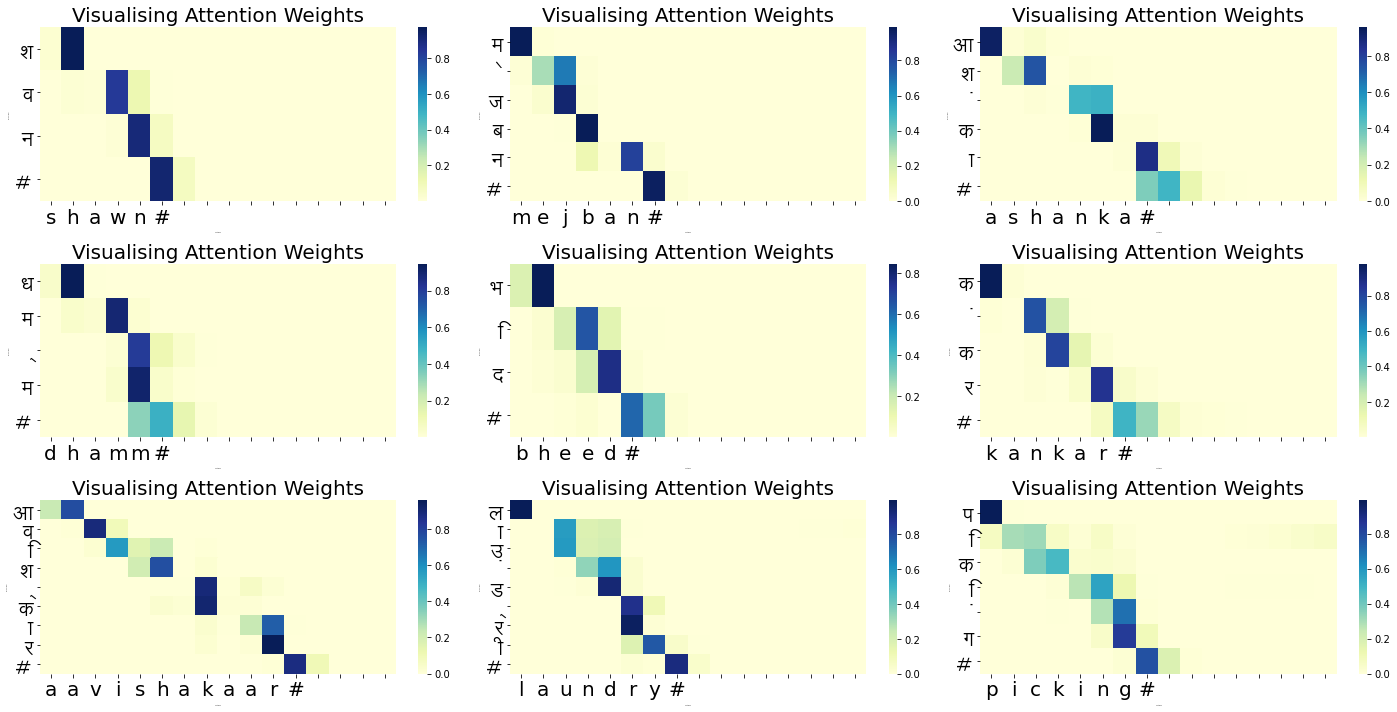

In [36]:
#Generate Attention heatmaps
import warnings
warnings.filterwarnings("ignore")
from __future__ import unicode_literals
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib


f, g = plt.subplots(3,3,figsize=(20,10))
i = 0
for index, row in attention_random_sample.iterrows():
  
  sample_attention = np.array(row['attention_weights'])
  sample_attention = sample_attention.reshape((sample_attention.shape[0],sample_attention.shape[2]))
  decode = [ii for ii in row['predictions']]+['#']
  encode = [ii for ii in row['input_texts']]+['#']
  
  ax = sns.heatmap(sample_attention,linecolor= 'white', cbar=True,cmap="YlGnBu",yticklabels=decode,ax = g[i//3][i%3])
  ax.set_xticklabels(encode, fontsize=10, rotation=0)
  ax.set_yticklabels(decode,fontsize =10,rotation=0,fontproperties = fontprop)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  #plt.yticks(fontproperties = fontprop,fontsize =20)
  ax.set_xlabel('Input Word',fontsize=1)
  ax.set_ylabel('Decoded Word',fontsize = 1)
  ax.set_title('Visualising Attention Weights',fontsize = 20)
  
  i +=1

plt.tight_layout()
plt.savefig('heatmap_grid.png') 

# Visualisation

In [37]:
#  This is the Visualisation code cell

from IPython.display import HTML as html_print
from IPython.display import display
import keras.backend as K

def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

# sigmoid function
def sigmoid(x):
	z = 1/(1 + np.exp(-x)) 
	return z



def visualize(attention_weights,input,output_index,decoded_sentence):
  text_colours = []
  for i in range(len(input)):
    text = (input[i], get_clr(attention_weights[output_index][i]))
    text_colours.append(text)
  print_color(text_colours)
  text_colours = []
  for i in range(len(decoded_sentence)):
    if(i == output_index):
          text = (decoded_sentence[i], get_clr(sigmoid(1)))
    else :
          text = (decoded_sentence[i], get_clr(sigmoid(0)))
    text_colours.append(text)
    print_color(text_colours)
    text_colours = []


In [38]:
from IPython.display import clear_output
import time


# params
#<attention_weights> : It's an attention weight matrix .
#<input_text> : It is input text
#<prediction_text> : It is predicted text
def visualize_attn(attention_weights,input_text,prediction_text):
    
    sample_attention = np.array(attention_weights)
    sample_attention = sample_attention.reshape((sample_attention.shape[0],sample_attention.shape[2]))
    alpha = sigmoid(sample_attention)

    for i in range(len(prediction_text)):
        clear_output(wait=True)
        visualize(alpha,input_text,i,prediction_text)
        time.sleep(1)

## Visualisation on 9 samples from test

In [42]:
for indx,row in attention_random_sample.iterrows():
  visualize_attn(row['attention_weights'],row['input_texts'],row['predictions'])
  time.sleep(1)

In [40]:
# Let's try visualisation on random samples that we took from test data step by step if u feel for loop is too fast
x = attention_random_sample.iterrows()

## Execute the below cell 9 times to get visualisation of 9 random samples chosen

In [41]:
indx,row = next(x)
visualize_attn(row['attention_weights'],row['input_texts'],row['predictions'])